## 0. Current Process on Building Class "analyzer"

This shows the current work process on building new class "analyzer", by now the initialization part and first two features are done. **a copy of code below is stored into analyzer.py to test how it runs on terminal**

In [ ]:
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import ast
import matplotlib.pyplot as plt

os.chdir("..\\models")
import datafetchtools #I tried to put two functions dedicated for downloading and unzipping the data into a .py file


from typing import Union

class analyzer:
    """
    A class to perform three kinds of quick analysis for movie data from CMU dataset. By calling the built-in methods,
    the analyzer object can generate indicated pandas DataFrame, and return plot generated by matplotlib(if possible).
    ...

    Attributes
    ----------
    gzipPath : str
        default path for downloading and storing the original ".tar.gz" file downloaded from the official link.
    movieMetaDataPath : str
        default path for storing 'movie.metadata.tsv' extracted from zipped file.
    movieMetaDataColumns : list
        list of default column names for movieData
    movieData: pandas.DataFrame
        DataFrame of movie data loaded from 'movie.metadata.tsv'
    characterMetaDataPath : str
        default path for storing character.metadata.tsv extracted from zipped file.
    characterMetaDataColumns : list
        list of default column names for characterData
    characterData : pandas.DataFrame
        DataFrame of character data loaded fron 'character.metadata.tsv' 

    Methods
    -------
    movie_type(N=10):
        Return a panda.Series showing how many times a genre in top N genres shows up in the database.
    actor_count():
        Return a histogram of "number of actors" vs "movie counts". 
    actor_distributions():
        Return an actor data in pandas.DataFrame under 3 given conditions or plot the distribution of filtered actorData.
    """

    def __init__(self):
        # Indicate paths and creates lists for column names
        self.gzipPath="..\\downloads\\MovieSummaries.tar.gz"
        self.movieMetaDataPath="..\\data\\MovieSummaries\\movie.metadata.tsv"
        self.movieMetaDataColumns=['wikiID', 'fbID', 'movieName', 'releaseDate', 'boxRevenue', 'runtime', 'language', 'country', 'genre']
        self.characterMetaDataPath="..\\data\\MovieSummaries\\character.metadata.tsv"
        self.characterMetaDataColumns=['wikiID', 'fbID', 'releaseDate', 'characterName', 'actorBirthday', 'actorGender', 'actorHeight', 
                                       'actorEthnicityID','actorName', 'ageAtRelease', 'fbMapID', 'fbCharacterID','fbActorID']
        
        try:
            # try to load datasets
            print("Connceting to the datasets ...")
            self.movieData=pd.read_csv(self.movieMetaDataPath, sep="\t", names=self.movieMetaDataColumns, on_bad_lines='skip')
            self.characterData=pd.read_csv(self.characterMetaDataPath, sep="\t", names=self.characterMetaDataColumns, on_bad_lines='skip')  

        except:
            # if the datasets don't exist in the local directory
            datafetchtools.downloadData("https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz", self.gzipPath)
            datafetchtools.extractData("..\\downloads\\MovieSummaries.tar.gz", "..\\data")

        finally:
            # load again
            self.movieData=pd.read_csv(self.movieMetaDataPath, sep="\t", names=self.movieMetaDataColumns, on_bad_lines='skip')
            self.characterData=pd.read_csv(self.characterMetaDataPath, sep="\t", names=self.characterMetaDataColumns, on_bad_lines='skip')
            print("Successfully connected to the datasets")

    def movie_type(self, N: int =10) -> pd.Series:
        """
        Calculate a non-duplicated pandas.Series with columns same as genres in the movie data and how many times they show up.

        Args:
            N(int): Show only top N genre

        Returns:
            pandas.Series: The movie type counts data

        Example:
            >>> movieAnalyzer = analyzer()
            >>> analyzer.movie_type(N=5)
        """
        if type(N) != int:
            raise TypeError("'N' must be an integer!")
        
        # Take the column "genres" out and form lists using the values of dictionary 
        genres=self.movieData.genre.apply(lambda x: list(ast.literal_eval(x).values()))
        # A native feature of pandas that breaks down columns made of list into new entries
        genresExploded=genres.explode(ignore_index=True)
        genresExploded.rename("Movie_Type", inplace=True)
        return genresExploded.value_counts()[1:N]
    
    def actor_count(self) -> plt.figure:
        """
        Plot a histogram of "Number of Actors" vs. "Movie Counts"

        Returns:
            matplotlib.pyplot.figure: A figure showing the histogram

        Example:
            >>> movieAnalyzer = analyzer()
            >>> movieAnalyzer.actor_count()
        """

        # Use value_counts() to count how many times a wikiID occurs in the Character dataset
        # Create a new dataframe using .join(), having columns: wikiID, movieName, actorCounts
        countData=self.movieData[["wikiID", "movieName"]].join(self.characterData['wikiID'].value_counts().astype("Int64"), on="wikiID")
        countData.rename(columns={"count": "actorCounts"}, inplace=True)

        # Make sure can be executed in terminal and return a figue
        plt.figure(figsize=(8, 6))
        sns.histplot(data=countData,x="actorCounts",bins=40)
        plt.xlabel("Number of Actors")
        plt.ylabel("Movie Counts")
        plt.title("Number of Actors vs. Movie Counts")
        plt.show()
    
    def actor_distributions(self, max_height: float = 3.0, min_height:float = 0.0, gender:str = "All", plot:bool = False) -> Union[pd.DataFrame, plt.figure]:
        """
        Calculate a non-duplicated actor data with actors' name, gender and height under three search conditions. 
        Set `plot` to true to plot histogram.

        Args:
            max_height(float): The maximum height float number.
            max_height(float): The minimum height in float number.
            gender(str): Actor gender in string, choose from "M", "F" and "All"

        Returns:
            pandas.DataFrame: The actor data under search conditions
            matplotlib.pylot.figure: A figure showing the distribution in histogram

        Example:
            >>> movieAnalyzer = analyzer()
            >>> analyzer.actor_distributions(max_height=2.2, min_height=1.0)
        """

        if type(gender) != str:
            raise TypeError("'gender' must be a string")
        
        if not isinstance(max_height, (int, float)) or not isinstance(min_height, (int, float)):
            raise TypeError("'max_height' and 'min_height' should be numerical values")
        
        actorData = self.characterData[["actorName", "actorGender", "actorHeight"]].drop_duplicates()

        if gender == "All":
            actorDataConstraint=actorData
        else:
            actorDataConstraint=actorData[actorData.actorGender == gender]
        
        actorDataConstraint=actorDataConstraint[(actorDataConstraint.actorHeight > min_height) 
                                                    & (actorDataConstraint.actorHeight < max_height)]
        if plot == True:
            plt.figure(figsize=(12, 6))
            sns.histplot(actorDataConstraint, x="actorHeight")
            plt.xlabel("Actor Height")
            plt.ylabel("Number of Actors")
            plt.show()
        else:
            return actorDataConstraint



In [ ]:
analyzer().actor_distributions()

Connceting to the datasets ...
Successfully connected to the datasets


Movie_Type
Comedy             16349
Romance Film       10234
Black-and-white     9094
Action              8798
Thriller            8744
Short Film          8141
World cinema        7155
Crime Fiction       6948
Indie               6897
Name: count, dtype: int64

## 1. Finding solutions for required features in Jupyter environment

This part is used to load data, process them, and get ideal result as usual in a .ipynb environment. `dfm` and `dfc` are correctly loaded movie data and character data (same as those in the class "analyzer")

In [4]:
dfm=pd.read_csv("..\\data\\MovieSummaries\\movie.metadata.tsv", 
               sep="\t", 
               names=['wikiID', 'fbID', 'movieName', 'releaseDate', 'boxRevenue', 'runtime', 'language', 'country', 'genre'])

In [8]:
dfc=pd.read_csv("..\\data\\MovieSummaries\\character.metadata.tsv", 
               sep="\t", 
               names=['wikiID', 'fbID', 'releaseDate', 'characterName', 'actorBirthday', 'actorGender', 'actorHeight',
                      'actorEthnicityID','actorName', 'ageAtRelease', 'fbMapID', 'fbCharacterID','fbActorID'])

In [11]:
sorted(dfc.actorHeight.unique())

[np.float64(0.61),
 np.float64(1.524),
 np.float64(1.55),
 np.float64(1.56),
 np.float64(1.57),
 np.float64(1.575),
 np.float64(1.59),
 np.float64(1.6),
 np.float64(1.6002),
 np.float64(1.61),
 np.float64(1.62),
 np.float64(1.626),
 np.float64(1.63),
 np.float64(1.64),
 np.float64(1.65),
 np.float64(1.67),
 np.float64(1.676),
 np.float64(1.68),
 np.float64(1.715),
 np.float64(1.727),
 np.float64(1.75),
 np.float64(1.753),
 np.float64(1.78),
 np.float64(nan),
 np.float64(0.813),
 np.float64(0.83),
 np.float64(0.88),
 np.float64(0.94),
 np.float64(1.0),
 np.float64(1.06),
 np.float64(1.067),
 np.float64(1.07),
 np.float64(1.09728),
 np.float64(1.1176),
 np.float64(1.12),
 np.float64(1.14),
 np.float64(1.143),
 np.float64(1.168),
 np.float64(1.17),
 np.float64(1.19),
 np.float64(1.194),
 np.float64(1.21),
 np.float64(1.219),
 np.float64(1.22),
 np.float64(1.23),
 np.float64(1.24),
 np.float64(1.262),
 np.float64(1.27),
 np.float64(1.29),
 np.float64(1.3),
 np.float64(1.32),
 np.float64(1.

In [11]:
dfc.head()

,wikiID,fbID,releaseDate,characterName,actorBirthday,actorGender,actorHeight,actorEthnicityID,actorName,ageAtRelease,fbMapID,fbCharacterID,fbActorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [19]:
dfa=dfc[["actorName", "actorGender", "actorHeight"]].drop_duplicates()
dfa.drop_duplicates()['actorGender'].value_counts()

actorGender
M    60922
F    35720
Name: count, dtype: int64

In [6]:
df_ac=dfm[["wikiID", "movieName"]].join(dfc['wikiID'].value_counts().astype("Int64"), on="wikiID")
df_ac.rename(columns={"count": "actorCounts"}, inplace=True)

<Axes: xlabel='actorCounts', ylabel='Count'>

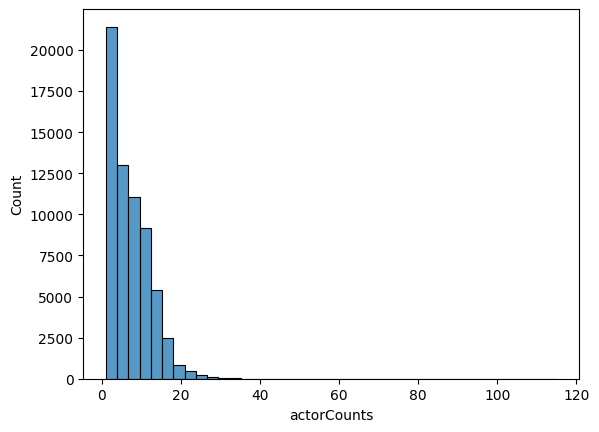

In [7]:
sns.histplot(data=df_ac,x="actorCounts",bins=40)

In [8]:
dfm["genre"].apply(lambda x: list(ast.literal_eval(x).values())).explode(ignore_index=True).value_counts()[0:10]

genre
Drama              34007
Comedy             16349
Romance Film       10234
Black-and-white     9094
Action              8798
Thriller            8744
Short Film          8141
World cinema        7155
Crime Fiction       6948
Indie               6897
Name: count, dtype: int64

In [9]:
dfm.releaseDate.str[0:4]

0        2001
1        2000
2        1988
3        1987
4        1983
         ... 
81736    2011
81737    2011
81738    1972
81739    1992
81740    2002
Name: releaseDate, Length: 81741, dtype: object

In [10]:
dfm.genre=dfm.genre.apply(lambda x: list(ast.literal_eval(x).values()))
#df.language=df.language.apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)